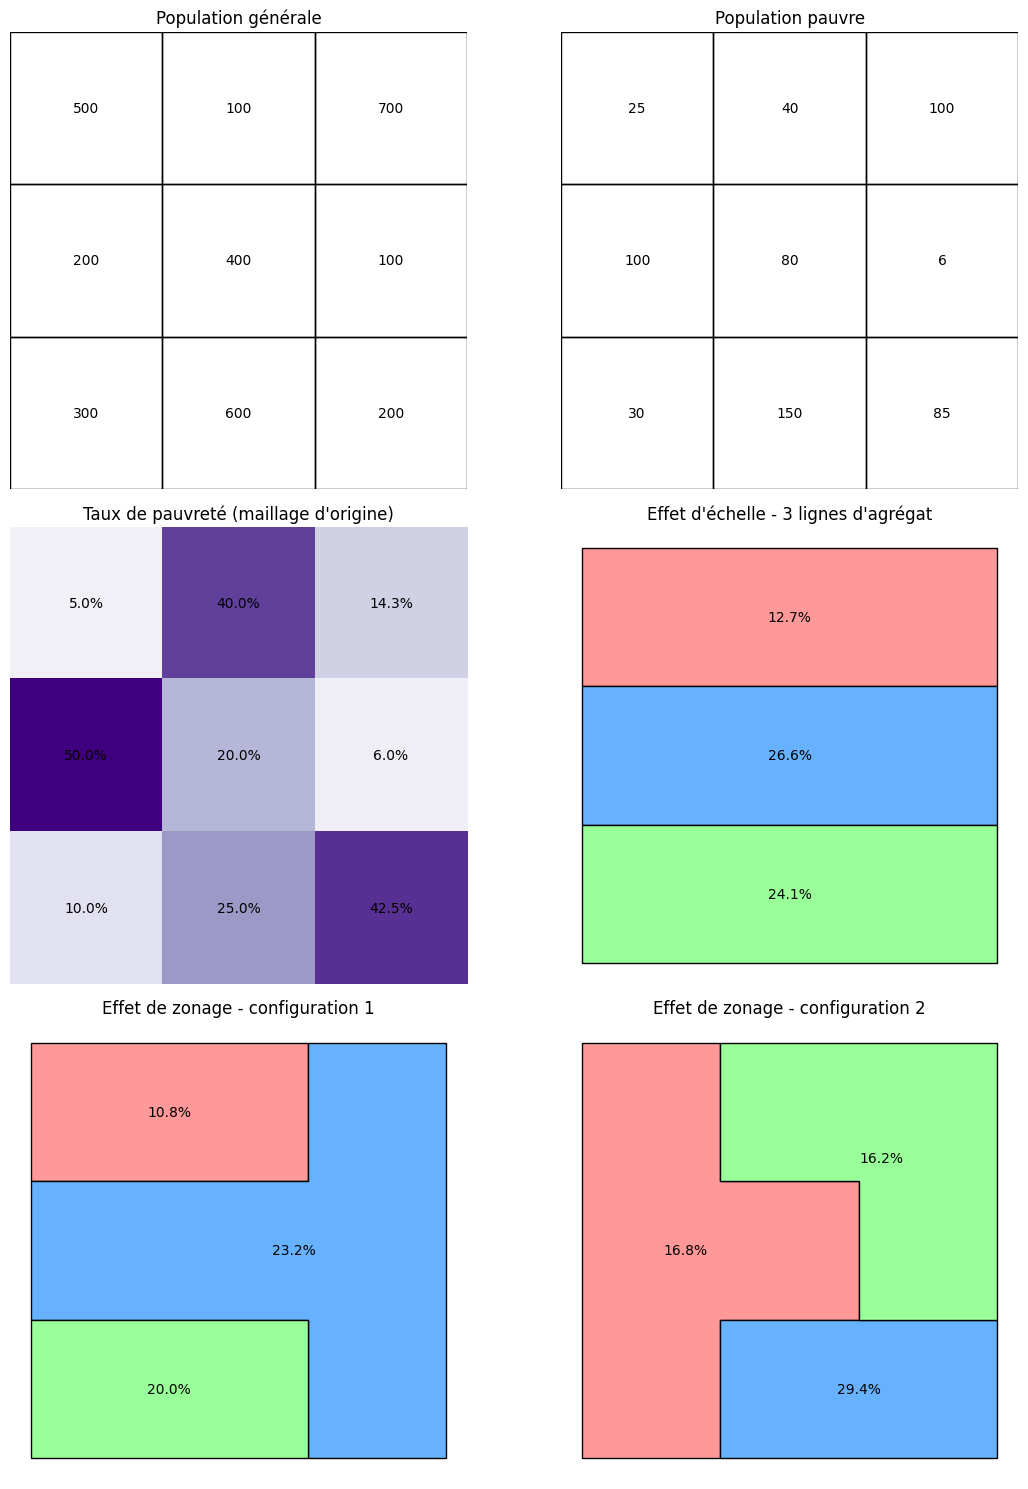

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon
from shapely.ops import unary_union
import numpy as np

# Dimensions de la grille (3x3)
rows, cols = 3, 3
cell_size = 1

# Population générale et population pauvre
population = np.array([
    [500, 100, 700],
    [200, 400, 100],
    [300, 600, 200]
])
population_poor = np.array([
    [25, 40, 100],
    [100, 80, 6],
    [30, 150, 85]
])

population_2 = np.array([
    [100, 100, 100],
    [100, 100, 100],
    [100, 100, 100]
])
population_poor_2 = np.array([
    [10, 10, 10],
    [10, 10, 10],
    [10, 10, 10]
])


# Calcul du taux de pauvreté en %
poverty_rate = (population_poor / population) * 100

# Création des cellules de la grille comme polygones Shapely
grid_cells = []
for i in range(rows):
    row_cells = []
    for j in range(cols):
        # Définition de chaque cellule comme un polygone
        cell = Polygon([
            (j * cell_size, i * cell_size),
            ((j + 1) * cell_size, i * cell_size),
            ((j + 1) * cell_size, (i + 1) * cell_size),
            (j * cell_size, (i + 1) * cell_size)
        ])
        row_cells.append(cell)
    grid_cells.append(row_cells)

# Effet d'échelle : regrouper les cellules pour 3 lignes d'agrégat
scale_effect_cells = [[(0, 0), (0, 1), (0, 2)], [(1, 0), (1, 1), (1, 2)], [(2, 0), (2, 1), (2, 2)]]
scale_effect_poverty = [
    (sum(population_poor[i, j] for i, j in group) / sum(population[i, j] for i, j in group)) * 100
    for group in scale_effect_cells
]


# Nouvelles configurations de zonage contiguës
zone1_cells = [[(0, 0),(0, 1), ],  # Première ligne
               [(1, 0), (1, 1), (1, 2),(0, 2),(2, 2)],  # Deuxième ligne
               [(2, 0), (2, 1),]]  # Troisième ligne

zone2_cells = [[(0, 0), (1, 0),(1, 1), (2, 0)],  # Première colonne
               [ (2, 2),  (2, 1)],  # Deuxième colonne
               [(0, 1),(0, 2),(1, 2)]]  # Troisième colonne

# Calcul des taux de pauvreté pour chaque zone
zone1_poverty = []
for group in zone1_cells:
    total_population = sum(population[i, j] for i, j in group)
    total_population_poor = sum(population_poor[i, j] for i, j in group)
    poverty_rate_zone = (total_population_poor / total_population) * 100 if total_population > 0 else 0
    zone1_poverty.append(poverty_rate_zone)

zone2_poverty = []
for group in zone2_cells:
    total_population = sum(population[i, j] for i, j in group)
    total_population_poor = sum(population_poor[i, j] for i, j in group)
    poverty_rate_zone = (total_population_poor / total_population) * 100 if total_population > 0 else 0
    zone2_poverty.append(poverty_rate_zone)


# Affichage
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

white_cmap = ListedColormap(["white"])

# Population générale
ax[0, 0].imshow(population, cmap=white_cmap, vmin=0, vmax=700)
for (i, j), val in np.ndenumerate(population):
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
    ax[0, 0].add_patch(rect)
    ax[0, 0].text(j, i, f"{val}", ha='center', va='center', color="black")
ax[0, 0].set_title("Population générale")
ax[0, 0].axis('off')

# Population pauvre avec fond blanc et contour
ax[0, 1].imshow(population_poor, cmap=white_cmap, vmin=0, vmax=150)
for (i, j), val in np.ndenumerate(population_poor):
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
    ax[0, 1].add_patch(rect)
    ax[0, 1].text(j, i, f"{val}", ha='center', va='center', color="black")
ax[0, 1].set_title("Population pauvre")
ax[0, 1].axis('off')

# Taux de pauvreté (maillage d'origine)
ax[1, 0].imshow(poverty_rate, cmap="Purples", vmin=0, vmax=50)
for (i, j), val in np.ndenumerate(poverty_rate):
    ax[1, 0].text(j, i, f"{val:.1f}%", ha='center', va='center', color="black")
ax[1, 0].set_title("Taux de pauvreté (maillage d'origine)")
ax[1, 0].axis('off')

# Effet d'échelle (3 lignes d'agrégat)
colors = ["#FF9999", "#66B2FF", "#99FF99"]
for k, group in enumerate(scale_effect_cells):
    union_poly = unary_union([grid_cells[i][j] for i, j in group])
    x, y = union_poly.exterior.xy
    ax[1, 1].fill(x, y, color=colors[k % len(colors)], edgecolor="black")
    ax[1, 1].text(union_poly.centroid.x, union_poly.centroid.y, f"{scale_effect_poverty[k]:.1f}%", ha="center", va="center")
ax[1, 1].set_title("Effet d'échelle - 3 lignes d'agrégat")
ax[1, 1].axis('off')
ax[1, 1].invert_yaxis() 
ax[1, 1].set_aspect("equal")

# Effet de zonage : configuration 1 (zones par lignes)
for k, group in enumerate(zone1_cells):
    union_poly = unary_union([grid_cells[i][j] for i, j in group])
    
    if union_poly.geom_type == 'Polygon':
        x, y = union_poly.exterior.xy
        ax[2, 0].fill(x, y, color=colors[k % len(colors)], edgecolor="black")
        ax[2, 0].text(union_poly.centroid.x, union_poly.centroid.y, f"{zone1_poverty[k]:.1f}%", ha="center", va="center")
    elif union_poly.geom_type == 'MultiPolygon':
        for poly in union_poly.geoms:
            x, y = poly.exterior.xy
            ax[2, 0].fill(x, y, color=colors[k % len(colors)], edgecolor="black")
            ax[2, 0].text(poly.centroid.x, poly.centroid.y, f"{zone1_poverty[k]:.1f}%", ha="center", va="center")

ax[2, 0].set_title("Effet de zonage - configuration 1")
ax[2, 0].axis('off')
ax[2, 0].invert_yaxis()  
ax[2, 0].set_aspect("equal")

# Effet de zonage : configuration 2 (zones par colonnes)
for k, group in enumerate(zone2_cells):
    union_poly = unary_union([grid_cells[i][j] for i, j in group])
    
    if union_poly.geom_type == 'Polygon':
        x, y = union_poly.exterior.xy
        ax[2, 1].fill(x, y, color=colors[k % len(colors)], edgecolor="black")
        ax[2, 1].text(union_poly.centroid.x, union_poly.centroid.y, f"{zone2_poverty[k]:.1f}%", ha="center", va="center")
    elif union_poly.geom_type == 'MultiPolygon':
        for poly in union_poly.geoms:
            x, y = poly.exterior.xy
            ax[2, 1].fill(x, y, color=colors[k % len(colors)], edgecolor="black")
            ax[2, 1].text(poly.centroid.x, poly.centroid.y, f"{zone2_poverty[k]:.1f}%", ha="center", va="center")

ax[2, 1].set_title("Effet de zonage - configuration 2")
ax[2, 1].axis('off')
ax[2, 1].invert_yaxis() 
ax[2, 1].set_aspect("equal")

plt.tight_layout()
plt.show()
